# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

[]
Slusarski


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network
Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

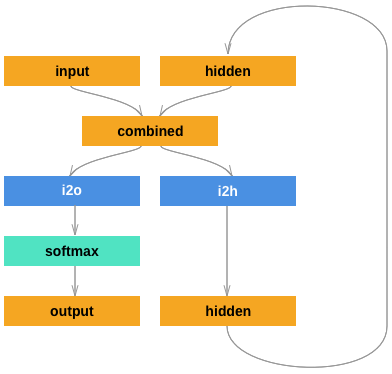

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [18]:
#网络结构
# 导入必要的库
from torchviz import make_dot
from torchsummary import summary
import torch

# 方法1: 使用torchviz生成RNN网络结构图
input_example = torch.zeros(1, n_letters)  # 创建一个示例输入
hidden = torch.zeros(1, n_hidden)  # 创建一个示例隐藏状态
output, next_hidden = rnn(input_example, hidden)  # 前向传播

# 生成计算图并保存为PNG
dot = make_dot(output, params=dict(rnn.named_parameters()))
dot.render("./rnn_structure", format="png")



'rnn_structure.png'

LSTM模型实现

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        # 输入门组件
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        # 遗忘门组件
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        # 输出门组件
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)
        # 单元状态组件
        self.cell_gate = nn.Linear(input_size + hidden_size, hidden_size)
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden_state):
        h, c = hidden_state
        
        # 合并输入和隐藏状态
        combined = torch.cat((input, h), 1)
        
        # 计算各个门的值
        i = torch.sigmoid(self.input_gate(combined))
        f = torch.sigmoid(self.forget_gate(combined))
        o = torch.sigmoid(self.output_gate(combined))
        g = torch.tanh(self.cell_gate(combined))
        
        # 更新单元状态和隐藏状态
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        
        # 计算输出
        output = self.output_layer(h_next)
        output = self.softmax(output)
        
        return output, (h_next, c_next)
    
    def initHidden(self):
        # 返回隐藏状态和单元状态
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))

# 使用示例
n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

GRU模型实现

In [ ]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        
        self.hidden_size = hidden_size
        
        # 重置门组件
        self.reset_gate = nn.Linear(input_size + hidden_size, hidden_size)
        # 更新门组件
        self.update_gate = nn.Linear(input_size + hidden_size, hidden_size)
        # 候选隐藏状态组件
        self.h_tilde = nn.Linear(input_size + hidden_size, hidden_size)
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        # 合并输入和隐藏状态
        combined = torch.cat((input, hidden), 1)
        
        # 计算门的值
        r = torch.sigmoid(self.reset_gate(combined))
        z = torch.sigmoid(self.update_gate(combined))
        
        # 计算候选隐藏状态
        combined_reset = torch.cat((input, r * hidden), 1)
        h_tilde = torch.tanh(self.h_tilde(combined_reset))
        
        # 更新隐藏状态
        h_next = (1 - z) * hidden + z * h_tilde
        
        # 计算输出
        output = self.output_layer(h_next)
        output = self.softmax(output)
        
        return output, h_next
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# 使用示例
n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [5]:
input = letterToTensor('A')
print(input.size())
hidden = torch.zeros(1, n_hidden)

# h, c = rnn.initHidden()
# output = rnn(input.unsqueeze(1), h, c)

hidden = rnn.initHidden()               # 只拿 1 个张量
output, next_hidden = rnn(input, hidden)

torch.Size([1, 57])


For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [6]:
# input = lineToTensor('Albert')
# print(input.size())
# hidden = torch.zeros(1, n_hidden)

# h, c = rnn.initHidden()
# output, h, c = rnn(input, h, c)

# print(torch.exp(output))
input = lineToTensor("Albert")        # [6, 1, 57]
hidden = rnn.initHidden()             # 只要 h

for i in range(input.size(0)):        # 按时间步送进去
    out, hidden = rnn(input[i], hidden)

print(torch.exp(out))                 # 最后一个时间步的 softmax 概率

tensor([[0.0507, 0.0582, 0.0536, 0.0562, 0.0513, 0.0596, 0.0578, 0.0549, 0.0539,
         0.0570, 0.0545, 0.0521, 0.0582, 0.0617, 0.0590, 0.0536, 0.0556, 0.0522]],
       grad_fn=<ExpBackward0>)


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 13)


We will also want a quick way to get a training example (a name and its language):

In [21]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Shon
category = Scottish / line = Ferguson
category = French / line = Samson
category = Italian / line = Natale
category = Dutch / line = Aart
category = Irish / line = Adam
category = Dutch / line = Pander
category = French / line = Coupe
category = Scottish / line = Marshall
category = Spanish / line = Gallo


### Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [20]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

#     print(line_tensor.size())
#     for i in range(line_tensor.size()[0]):
#         output, hidden = rnn(line_tensor[i], hidden)
    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output[-1])
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

训练集大小: 1998
验证集大小: 18076
迭代 1000 1.00% (0m 0s) 损失: 0.4437 Kumiega / Polish ✓
训练准确率: 0.6690, 验证准确率: 0.5750
迭代 2000 2.00% (0m 0s) 损失: 1.8513 Close / Scottish ✗ (Greek)
训练准确率: 0.7460, 验证准确率: 0.5350
迭代 3000 3.00% (0m 1s) 损失: 0.0224 Toloni / Italian ✓
训练准确率: 0.7870, 验证准确率: 0.5060
迭代 4000 4.00% (0m 1s) 损失: 0.1316 Casales / Spanish ✓
训练准确率: 0.7920, 验证准确率: 0.4660
迭代 5000 5.00% (0m 2s) 损失: 0.6423 Esparza / Spanish ✓
训练准确率: 0.7560, 验证准确率: 0.4550
迭代 6000 6.00% (0m 2s) 损失: 0.0753 Segawa / Japanese ✓
训练准确率: 0.7870, 验证准确率: 0.3780
迭代 7000 7.00% (0m 3s) 损失: 0.6082 Gomolka / Polish ✓
训练准确率: 0.8020, 验证准确率: 0.4320
迭代 8000 8.00% (0m 3s) 损失: 0.3793 Skala / Polish ✓
训练准确率: 0.8350, 验证准确率: 0.4480
迭代 9000 9.00% (0m 4s) 损失: 7.4101 Acquafredda / Polish ✗ (Italian)
训练准确率: 0.7660, 验证准确率: 0.4270
迭代 10000 10.00% (0m 4s) 损失: 1.0929 De santigo / Spanish ✗ (Portuguese)
训练准确率: 0.8060, 验证准确率: 0.4250
迭代 11000 11.00% (0m 5s) 损失: 0.1481 Thean / Chinese ✓
训练准确率: 0.8330, 验证准确率: 0.4360
迭代 12000 12.00% (0m 5s) 损失: 1.7736 Kan / 

### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

/var/folders/54/1b_2l3z54lnbc758prwytbs40000gn/T/ipykernel_82387/1880753744.py:20: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/54/1b_2l3z54lnbc758prwytbs40000gn/T/ipykernel_82387/1880753744.py:20: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/54/1b_2l3z54lnbc758prwytbs40000gn/T/ipykernel_82387/1880753744.py:20: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/54/1b_2l3z54lnbc758prwytbs40000gn/T/ipykernel_82387/1880753744.py:20: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/54/1b_2l3z54lnbc758prwytbs40000gn/T/ipykernel_82387/1880753744.py:20: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/54/1b_2

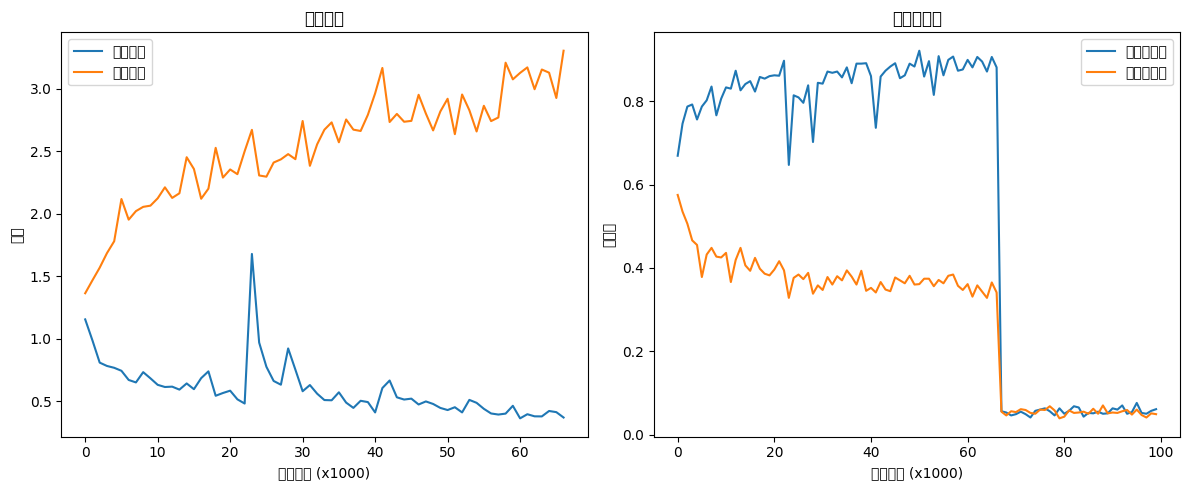

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

/var/folders/54/1b_2l3z54lnbc758prwytbs40000gn/T/ipykernel_82387/478124290.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/54/1b_2l3z54lnbc758prwytbs40000gn/T/ipykernel_82387/478124290.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


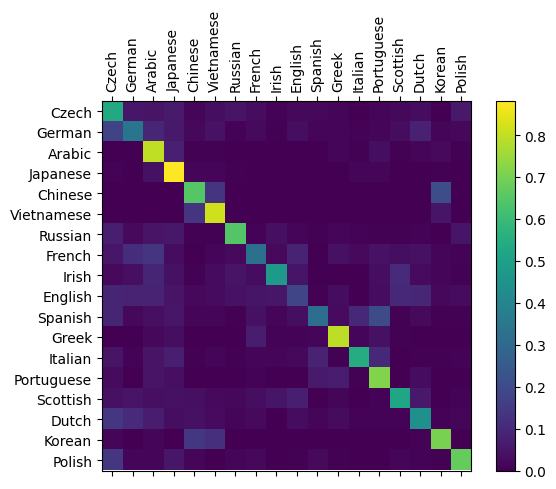

In [13]:
import numpy
%matplotlib inline
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
# def evaluate(line_tensor):
#     h0, c0 = rnn.initHidden()

# #     for i in range(line_tensor.size()[0]):
#     output = rnn(line_tensor, h0, c0)

#     return output[-1]
def evaluate(line_tensor):
    with torch.no_grad():                 # 评估阶段不算梯度
        hidden = rnn.initHidden()         # 只有 h

        for i in range(line_tensor.size(0)):      # 按时间步送入
            output, hidden = rnn(line_tensor[i], hidden)

    return output                         # 最后一步的输出

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

### Running on User Input

In [16]:
import math
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Hou')


> Dovesky
(0.50) Czech
(0.34) Russian
(0.09) Polish

> Jackson
(0.37) English
(0.22) Scottish
(0.15) Dutch

> Hou
(0.34) Korean
(0.29) Chinese
(0.24) Vietnamese
